## Latent Personal Analysis in Python
by Alex Abbey

This short tutorial will demonstrate how to use the Python implementation of LPA, as described in the [article](https://link.springer.com/article/10.1007/s11257-021-09295-7) in User Modeling and User-Adapted Interaction.

LPA helps analyze a corpus of text, or any set of data, by taking into account the missing popular elements and frequently used yet generally infrequent elements.

The first implementation for LPA was written by Hagit Ben-Shoshan in SQL and can be found [here](https://github.com/hagitbenshoshan/text_distance/) - 
For very large datasets, users of this package are encouraged to switch to the SQL implementation using cloud infrustructure, as the calculation of the results will be much faster.

Dependencies can be found in `requirements.txt`.

### Terminology

It can be useful to think of the basic unit of analysis as a word, which is part of a chapter, which is part of a book. To keep things general we'll use these terms:
* **Element** is the basic unit of analysis, i.e. a word
* **Documents** (or entities or categories) are compared to each other and in the context of their domain. **Local weight** is the normalized frequency of elements whithin a document. Each weighted entity's vector is termed Personal Vector Rates (**PVR**). 
* **Domain** (or world or corpus) consist of all of the categories, and is what the documents are compared to. The weighted domain vector is termed Domain Vector Rates (**DVR**).


In [1]:
import pandas as pd
from LPA import Corpus, sockpuppet_distance
import altair as alt
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In this tutorial we demonstrate LPA using a small portion of the LOCO dataset (Miani, 2021), the unprocessed data available here: https://osf.io/snpcg/. The data you are using should consist of a count of elements per document (bag of words). For instance, with this dataset, each document is an article, each element is a (tokenized) word, and the frequency is a count of the amount of times the word appeared in an article. The input should be a csv file with the columns: `element`, `document`, `frequency_in_document`. 

In [2]:
freq = pd.read_csv('./frequency.csv')
display(freq.head())
display(freq.describe(include="all"))

,document,element,frequency_in_document
0,C00001,know,4.0
1,C00001,associ,5.0
2,C00001,said,1.0
3,C00001,known,3.0
4,C00001,colonel,1.0


,document,element,frequency_in_document
count,34237,34237,34237.000000
unique,100,8201,NaN
top,C0006f,like,NaN
freq,1246,73,NaN
mean,NaN,NaN,1.811929
std,NaN,NaN,2.541179
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


#### Creating the domain
Start LPA by instantiating a `Corpus` object. `Corpus` can be instantiated either with a frequency DataFrame, as in the following code cell, or by sending it two Series, one of all documents and one of all elements.

The domain (DVR) consists of the frequency of all elements from all categories together. If the `Corpus` wasn't instantiated with a frequency dataframe, you must use it as an argument for `create_dvr()`.

In [3]:
corpus = Corpus(freq=freq)
dvr = corpus.create_dvr()
dvr

,element,global_weight
0,peopl,0.005126
1,us,0.005078
2,use,0.004755
3,world,0.004643
4,vaccin,0.004546
...,...,...
8196,jewri,0.000016
8197,jewelri,0.000016
8198,jetlin,0.000016
8199,jessica,0.000016


#### Setting the value of $\varepsilon$
No $\varepsilon$ (`epsilon`) is set by default. $\varepsilon$ should be proportionate to the size of the domain, so a recommended value is 1 / (domain size * `epsilon_frac`). In this case if `epsilon_frac` is a number greater than 1 will decrease the weight of $\varepsilon$ (the default weight given to missing terms) while a number between 0 and 1 will increase it.

In [4]:
epsilon_frac = 2
epsilon = 1 / (len(dvr) * epsilon_frac)
epsilon


6.0968174612852094e-05

#### Creating Signatures
Another common use of LPA is creating a signature for every document, which is made up of the most meaningful terms for every document, whether in their prominence or absence. Usually, one won't need the full signature, but rather signatures of a certain length, as shown in the paper.

Create signatures with `create_signatures()`. This will give you a list of signatures (dataframes) with the distance of your choice (KLD/ε) distances of all of the words in the corpus for each document, and a dataframe of the n most significant elements in the whole corpus (with the highest sum of absolute distances). Please note that signatures are computed between the documents and the DVR, so you must have created the dvr using `create_dvr()` before creating signatures.

Parameters:
* `epsilon` is the value of epsilon for computing KLDε distance.
* Use `sig_length` to cut the signatures to a certain length (defaults to 500), or use `None` if you don't want to cut the signatures at all.
* Use `distance` to choose which distance metric you want used to calculate the distance between each vector and the DVR. 
  * `"KLD"` for a symmetrized Kullback–Leibler divergence without epsilon modification
  * `"KLDe"` for a symmetrized Kullback–Leibler divergence with epsilon modification

In [5]:
signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
display(signatures[0].head(10))


aquino     0.044868
vaccin    -0.027897
new       -0.025693
abus       0.022595
michael    0.019577
victim     0.016493
child      0.015096
virus     -0.013058
world     -0.012939
state     -0.012001
Name: C00001, dtype: float64

Above you can see the signature of the first document, in which the elements "aquino", "abus", "michael", and "victim" are prominent, whereas "new" and "vaccin" are absent from document. Both the absent and prominent terms characterize the document. Additionally, the document is lacking the top 10 most prominent elements in the whole corpus (i.e. elements with largest absolute sum of distances from the domain).

To get a feel for the dataset as a whole, check the the distance of each document from the domain by computing the summed distance of the signatures:

<AxesSubplot:ylabel='Frequency'>

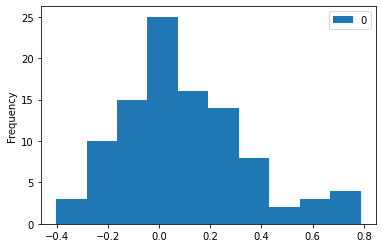

In [6]:
pd.DataFrame(
    [sig.sum() for sig in signatures], index=corpus.document_cat.categories
).plot.hist()
# pd.DataFrame([sig.sum() for sig in signatures])


#### Distances between pairs of categories (Sockpuppet Distance)
Finally, one can use the signatures created to calculate the L1 distance between every pair of categories. 
`sockpuppet_distance` accepts two Corpus classes of $n$ and $m$ signatures respectively and compares them, returning a matrix sized $n \times m$.

Parameters:
* `corpus1`, `corpus2` the two `Corpus` objects containing the signature matrices you want to compare (usually the same corpus twice but not necessarily) 
* `res` the form of the result wanted. Use `table` (default) for visualization (see further on in this notebook), or `matrix` if you want to see the sockpuppet distances in matrix form.
* `heuristic`: if True, adds 1 to the paisitive distances amd subtracts 1 from the negative distances, to create a clearer trend

In [7]:
spd = sockpuppet_distance(corpus, corpus)
spd.head()


,Corpus 1,Corpus 2,value
0,C00001,C00001,0.000000
1,C00003,C00001,0.879067
2,C00004,C00001,0.889110
3,C00005,C00001,0.842747
4,C00007,C00001,0.799605


#### Visualizing the results
The `sockpuppet_distance` function returns a matrix of distances between the categories. To visualize the results, use the `visualize` function. This function accepts the matrix returned by `sockpuppet_distance` and visualizes it using a heatmap.

In [8]:
from visualize import sockpuppet_matrix
sockpuppet_matrix(spd)


alt.Chart(...)

### Further analysis
Once we have calculated the distances between every category, we can perform further analysis on the results, for instance by clustering the sockpuppet distances and finding similar documents. 

In [9]:
from LPA import PCA
from visualize import plot_pca
spd = sockpuppet_distance(corpus, corpus, res="matrix")
pca, evr = PCA(spd, n_components=2)
display(plot_pca(pca,spd.index))
print(evr)


alt.LayerChart(...)

[0.62127218 0.04164387]


## Good Luck!

### References
Miani, A., Hills, T. & Bangerter, A. LOCO: The 88-million-word language of conspiracy corpus. Behav Res (2021). https://doi.org/10.3758/s13428-021-01698-z

Mokryn, O., Ben-Shoshan, H. Domain-based Latent Personal Analysis and its use for impersonation detection in social media. User Model User-Adap Inter 31, 785–828 (2021). https://doi.org/10.1007/s11257-021-09295-7